<a href="https://colab.research.google.com/github/Stan-Leigh/predict-stock-news-headlines/blob/main/Predict_Stock_News_Headlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [140]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

In [112]:
df = pd.read_csv('/content/drive/My Drive/2.Stock Sentiment Analysis/Data.csv', encoding='ISO-8859-1')

## Data Preprocessing

In [113]:
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite
2,2000-01-05,0,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,...,South Melbourne (Australia),Necaxa (Mexico),Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil),Tony's pet project,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links
3,2000-01-06,1,Pilgrim knows how to progress,Thatcher facing ban,McIlroy calls for Irish fighting spirit,Leicester bin stadium blueprint,United braced for Mexican wave,"Auntie back in fashion, even if the dress look...",Shoaib appeal goes to the top,Hussain hurt by 'shambles' but lays blame on e...,...,Putin admits Yeltsin quit to give him a head s...,BBC worst hit as digital TV begins to bite,How much can you pay for...,Christmas glitches,"Upending a table, Chopping a line and Scoring ...","Scientific evidence 'unreliable', defence claims",Fusco wins judicial review in extradition case,Rebels thwart Russian advance,Blair orders shake-up of failing NHS,Lessons of law's hard heart
4,2000-01-07,1,Hitches and Horlocks,Beckham off but United survive,Breast cancer screening,Alan Parker,Guardian readers: are you all whingers?,Hollywood Beyond,Ashes and diamonds,Whingers - a formidable minority,...,Most everywhere: UDIs,Most wanted: Chloe lunettes,Return of the cane 'completely off the agenda',From Sleepy Hollow to Greeneland,Blunkett outlines vision for over 11s,"Embattled Dobson attacks 'play now, pay later'...",Doom and the Dome,What is the north-south divide?,Aitken released from jail,Gone aloft


### Data description
Label 1 means that Stock price will increase with respect to the headlines in that row. Label 0 means that Stock price remains constant or reduces with respect to the headlines in that row.

In [114]:
# separate train and test data. Future dates cannot be in the train data and vice versa
train = df[df['Date'] < '20150101']
test = df[df['Date'] > '20141231']

In [115]:
# separate date and label columns
data = train.iloc[:, 2:]

In [116]:
data.columns

Index(['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9',
       'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17',
       'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25'],
      dtype='object')

In [117]:
# remove all characters that are not letters of the alphabet
data.replace('[^a-zA-Z]', ' ', inplace=True)

In [118]:
# rename all the columns
new_colnames = [str(col) for col in range(25)]

data.columns = new_colnames

data.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [119]:
# convert all the texts in the dataset to lowercase for uniformity
for col in new_colnames:
  data[col] = data[col].str.lower()

In [120]:
data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,a 'hindrance to operations': extracts from the...,scorecard,hughes' instant hit buoys blues,jack gets his skates on at ice-cold alex,chaos as maracana builds up for united,depleted leicester prevail as elliott spoils e...,hungry spurs sense rich pickings,gunners so wide of an easy target,derby raise a glass to strupar's debut double,"southgate strikes, leeds pay the penalty",...,flintoff injury piles on woe for england,hunters threaten jospin with new battle of the...,kohl's successor drawn into scandal,the difference between men and women,"sara denver, nurse turned solicitor",diana's landmine crusade put tories in a panic,yeltsin's resignation caught opposition flat-f...,russian roulette,sold out,recovering a title
1,scorecard,the best lake scene,leader: german sleaze inquiry,"cheerio, boyo",the main recommendations,has cubie killed fees?,has cubie killed fees?,has cubie killed fees?,hopkins 'furious' at foster's lack of hannibal...,has cubie killed fees?,...,on the critical list,the timing of their lives,dear doctor,irish court halts ira man's extradition to nor...,burundi peace initiative fades after rebels re...,pe points the way forward to the ecb,campaigners keep up pressure on nazi war crime...,jane ratcliffe,yet more things you wouldn't know without the ...,millennium bug fails to bite


## Data Wrangling and Merging

We are going to take all the data from each row, merge them together as one big blob of text. We do this for every row and append each row text to a list. At the end, we have a list where each list index element signifies all the text in a row of the dataset.

In [121]:
headlines = []

for row in range(0, len(data)):
  headlines.append(' '.join([str(i) for i in data.iloc[row, 0:]]))


In [122]:
len(headlines)

3975

In [123]:
headlines[0]

"a 'hindrance to operations': extracts from the leaked reports scorecard hughes' instant hit buoys blues jack gets his skates on at ice-cold alex chaos as maracana builds up for united depleted leicester prevail as elliott spoils everton's party hungry spurs sense rich pickings gunners so wide of an easy target derby raise a glass to strupar's debut double southgate strikes, leeds pay the penalty hammers hand robson a youthful lesson saints party like it's 1999 wear wolves have turned into lambs stump mike catches testy gough's taunt langer escapes to hit 167 flintoff injury piles on woe for england hunters threaten jospin with new battle of the somme kohl's successor drawn into scandal the difference between men and women sara denver, nurse turned solicitor diana's landmine crusade put tories in a panic yeltsin's resignation caught opposition flat-footed russian roulette sold out recovering a title"

## Apply Bag of Words and Random Forest on the data

In [124]:
cv = CountVectorizer(ngram_range=(2,2))
X_train = cv.fit_transform(headlines)

In [125]:
rf = RandomForestClassifier(n_estimators=200, criterion='entropy')

In [126]:
rf.fit(X_train, train['Label'])

RandomForestClassifier(criterion='entropy', n_estimators=200)

Next, we preprocess the test data and let the model perform predictions

In [127]:
# separate date and label columns
test_data = test.iloc[:, 2:]

In [128]:
test_data.columns

Index(['Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7', 'Top8', 'Top9',
       'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15', 'Top16', 'Top17',
       'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23', 'Top24', 'Top25'],
      dtype='object')

In [129]:
# remove all characters that are not letters of the alphabet
test_data.replace('[^a-zA-Z]', ' ', inplace=True)

In [130]:
# rename all the columns
new_colnames = [str(col) for col in range(25)]

test_data.columns = new_colnames

test_data.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [131]:
# convert all the texts in the dataset to lowercase for uniformity
for col in new_colnames:
  test_data[col] = test_data[col].str.lower()

In [132]:
test_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
3723,most cases of cancer are the result of sheer b...,iran dismissed united states efforts to fight ...,poll: one in 8 germans would join anti-muslim ...,uk royal family's prince andrew named in us la...,some 40 asylum-seekers refused to leave the bu...,pakistani boat blows self up after india navy ...,sweden hit by third mosque arson attack in a week,940 cars set alight during french new year,salaries for top ceos rose twice as fast as av...,"norway violated equal-pay law, judge says: jud...",...,ukrainian minister threatens tv channel with c...,palestinian president mahmoud abbas has entere...,israeli security center publishes names of 50 ...,the year 2014 was the deadliest year yet in sy...,a secret underground complex built by the nazi...,restrictions on web freedom a major global iss...,austrian journalist erich mchel delivered a pr...,thousands of ukraine nationalists march in kiev,chinas new years resolution: no more harvestin...,authorities pull plug on russia's last politic...
3724,moscow-&gt;beijing high speed train will reduc...,two ancient tombs were discovered in egypt on ...,china complains to pyongyang after n korean so...,scotland headed towards being fossil fuel-free...,prime minister shinzo abe said monday he will ...,sex slave at centre of prince andrew scandal f...,gay relative of hamas founder faces deportatio...,the number of female drug addicts in iran has ...,"after decades of searching, the causeway for t...",india lost 64 tigers in 2014,...,the islamic state has approved a 2015 budget o...,"iceland to withdraw eu application, lift capit...",blackfield capital founder goes missing: the v...,rocket stage crashes back to earth in rural ch...,2 dead as aircraft bombs greek tanker in libya...,belgian murderer frank van den bleeken to die ...,czech president criticizes ukrainian pm; says ...,3 vietnamese jets join search for 16 missing f...,france seeks end to russia sanctions over ukraine,china scraps rare earths caps


In [133]:
test_transform = []

for row in range(0, len(test_data)):
  test_transform.append(' '.join([str(i) for i in test_data.iloc[row, 0:]]))


In [134]:
X_test = cv.transform(test_transform)

In [135]:
pred = rf.predict(X_test)
pred

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,

In [136]:
cm = confusion_matrix(test['Label'], pred)
cm

array([[139,  47],
       [  9, 183]])

Text(49.65000000000006, 0.5, 'Predicted labels')

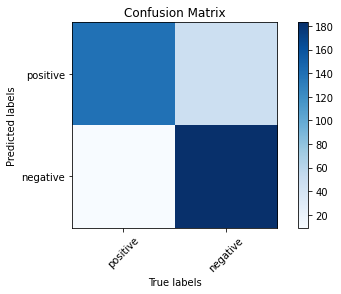

In [137]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
labels = ['positive', 'negative']
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.xlabel('True labels')
plt.ylabel('Predicted labels')

In [138]:
accuracy_score(test['Label'], pred)

0.8518518518518519

In [139]:
cr = classification_report(test['Label'], pred)
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.75      0.83       186
           1       0.80      0.95      0.87       192

    accuracy                           0.85       378
   macro avg       0.87      0.85      0.85       378
weighted avg       0.87      0.85      0.85       378



## Apply Naive Bayes on the data

In [141]:
nb = MultinomialNB()

In [142]:
nb.fit(X_train, train['Label'])

MultinomialNB()

In [143]:
pred = nb.predict(X_test)
pred

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [144]:
cm = confusion_matrix(test['Label'], pred)
cm

array([[137,  49],
       [  9, 183]])

Text(49.65000000000006, 0.5, 'Predicted labels')

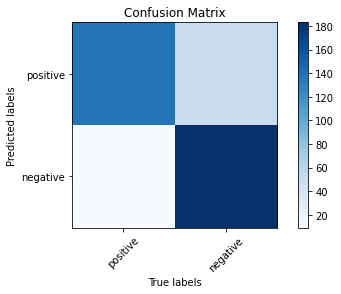

In [145]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
labels = ['positive', 'negative']
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.xlabel('True labels')
plt.ylabel('Predicted labels')

In [146]:
accuracy_score(test['Label'], pred)

0.8465608465608465

In [147]:
cr = classification_report(test['Label'], pred)
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.74      0.83       186
           1       0.79      0.95      0.86       192

    accuracy                           0.85       378
   macro avg       0.86      0.84      0.84       378
weighted avg       0.86      0.85      0.84       378

